## Data

Predict log GDP per capita of a nation as a function of two features from the dataset:
- whether the nation is in Africa
- its Terrain Ruggedness Index

/home/daniela/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


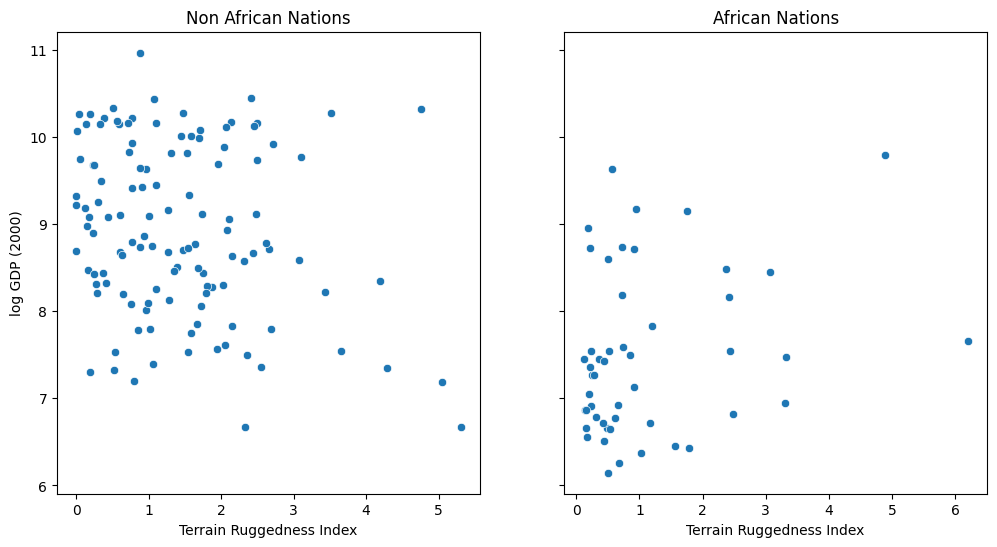

In [1]:
%reset -sf
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

import pyro
import pyro.distributions as dist
import pyro.optim as optim

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Regression model

In [2]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

## SVI

In [3]:
model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [4]:
pyro.clear_param_store()
num_iterations = 1500 if not smoke_test else 2

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
#     if j % 100 == 0:
#         print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

In [5]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

num_samples=800
predictive_svi = Predictive(model, guide=guide, num_samples=num_samples,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples_svi = predictive_svi(x_data)
pred_summary_svi = summary(samples_svi)

In [6]:
mu_svi = pred_summary_svi["_RETURN"]
y_svi = pred_summary_svi["obs"]
predictions_svi = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu_svi["mean"],
    "mu_perc_5": mu_svi["5%"],
    "mu_perc_95": mu_svi["95%"],
    "y_mean": y_svi["mean"],
    "y_perc_5": y_svi["5%"],
    "y_perc_95": y_svi["95%"],
    "true_gdp": y_data,
})

african_nations_svi = predictions_svi[predictions_svi["cont_africa"] == 1]
non_african_nations_svi = predictions_svi[predictions_svi["cont_africa"] == 0]
african_nations_svi = african_nations_svi.sort_values(by=["rugged"])
non_african_nations_svi = non_african_nations_svi.sort_values(by=["rugged"])

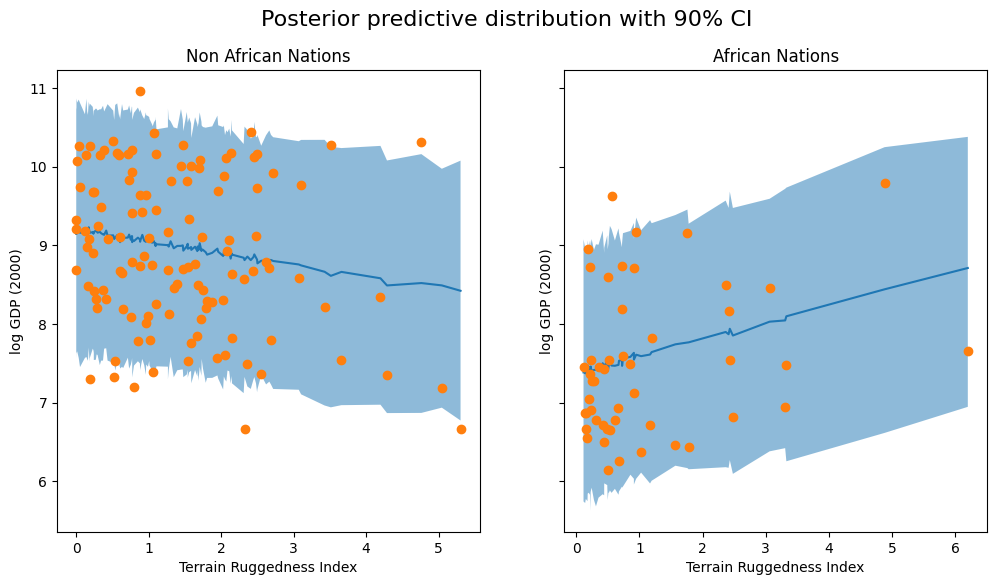

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations_svi["rugged"],
           non_african_nations_svi["y_mean"])
ax[0].fill_between(non_african_nations_svi["rugged"],
                   non_african_nations_svi["y_perc_5"],
                   non_african_nations_svi["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations_svi["rugged"],
           non_african_nations_svi["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations_svi["rugged"],
           african_nations_svi["y_mean"])
ax[1].fill_between(african_nations_svi["rugged"],
                   african_nations_svi["y_perc_5"],
                   african_nations_svi["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations_svi["rugged"],
           african_nations_svi["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

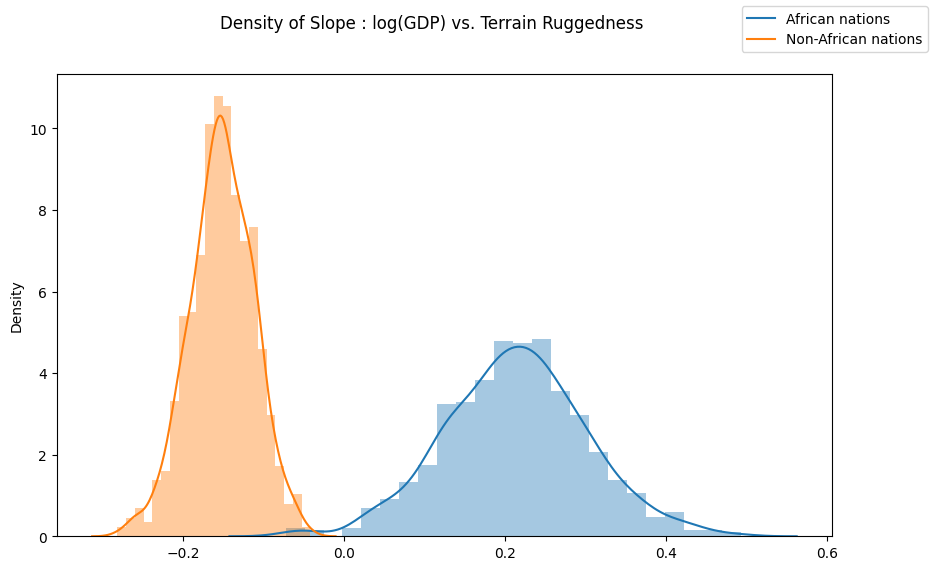

In [8]:
warnings.filterwarnings("ignore")

weight = samples_svi["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"})
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
fig.legend()

### Load as torch module

In [ ]:
# from collections import defaultdict
# from pyro import poutine
# from pyro.poutine.util import prune_subsample_sites
# import warnings


# class Predict(torch.nn.Module):
#     def __init__(self, model, guide):
#         super().__init__()
#         self.model = model
#         self.guide = guide

#     def forward(self, *args, **kwargs):
#         samples = {}
#         guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
#         model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
#         for site in prune_subsample_sites(model_trace).stochastic_nodes:
#             samples[site] = model_trace.nodes[site]['value']
#         return tuple(v for _, v in sorted(samples.items()))

In [ ]:
# # Evaluation: SVI
# predict_fn_svi = Predict(model, guide)
# predict_module_svi = torch.jit.trace_module(predict_fn_svi, {"forward": (x_data,)}, check_trace=False)

# torch.jit.save(predict_module_svi, '/tmp/reg_predict_svi.pt')
# pred_loaded_svi = torch.jit.load('/tmp/reg_predict_svi.pt')
# pred_loaded_svi(x_data)
# type(x_data)

In [ ]:
# warnings.filterwarnings("ignore")

# weight_load_svi = []
# for _ in range(800):
#     # index = 1 corresponds to "linear.weight"
#     weight_load_svi.append(pred_loaded_svi(x_data)[1])
    
# weight_load_svi = torch.stack(weight_load_svi).detach()
# weight_load_svi = weight_load_svi.reshape(weight_load_svi.shape[0], 3)
# gamma_within_africa_load_svi = weight_load_svi[:, 1] + weight_load_svi[:, 2]
# gamma_outside_africa_load_svi = weight_load_svi[:, 1]

# fig = plt.figure(figsize=(10, 6))
# sns.distplot(gamma_within_africa_load_svi, kde_kws={"label": "African nations"},)
# sns.distplot(gamma_outside_africa_load_svi, kde_kws={"label": "Non-African nations"})
# fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness")
# fig.legend()

## SVI + MCMC

In [43]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
# print(samples_svi)
# p1 = samples_svi["cont_africa"]
# p2 = samples_svi["rugged"]
# p3 = samples_svi["true_gdp"]

print(samples_svi["linear.weight"][0].shape)
print(samples_svi["linear.weight"].size())
print(y_data.shape)

svi_pred = Predictive(model, guide=guide, num_samples=len(y_data), return_sites=("linear.weight", "obs", "_RETURN"))(x_data, None)
svi_pred = svi_pred["linear.weight"]
print(svi_pred)
mcmc.run(svi_pred, y_data)

# predict_fn_svi_mcmc = Predict(model, guide)
# predict_module_svi_mcmc = torch.jit.trace_module(predict_fn_svi_mcmc, {"forward": (x_data,)}, check_trace=False)

# # Evaluation: SVI + MCMC
# torch.jit.save(predict_module_svi_mcmc, '/tmp/reg_predict_svi_mcmc.pt')
# pred_loaded_svi_mcmc = torch.jit.load('/tmp/reg_predict_svi_mcmc.pt')
# pred_loaded_svi_mcmc(x_data)

# mcmc.run(pred_loaded_svi_mcmc(x_data)[1])

# mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

torch.Size([1, 1, 3])
torch.Size([800, 1, 1, 3])
torch.Size([170])
tensor([[[[-2.0669, -0.1762,  0.3919]]],


        [[[-1.9282, -0.1530,  0.3300]]],


        [[[-2.0200, -0.1216,  0.3713]]],


        [[[-2.0509, -0.2163,  0.4133]]],


        [[[-1.8226, -0.1890,  0.3733]]],


        [[[-2.0197, -0.1849,  0.3978]]],


        [[[-1.8267, -0.1497,  0.2671]]],


        [[[-2.0585, -0.1783,  0.4256]]],


        [[[-1.8867, -0.1903,  0.3504]]],


        [[[-1.9225, -0.0885,  0.3577]]],


        [[[-1.7606, -0.1629,  0.4113]]],


        [[[-1.4978, -0.1293,  0.3496]]],


        [[[-1.8854, -0.1948,  0.4178]]],


        [[[-1.7697, -0.1491,  0.3131]]],


        [[[-1.9504, -0.2056,  0.4842]]],


        [[[-1.9950, -0.2014,  0.2549]]],


        [[[-1.8492, -0.1968,  0.4062]]],


        [[[-1.8849, -0.1510,  0.3246]]],


        [[[-1.8904, -0.0940,  0.1804]]],


        [[[-1.5942, -0.1408,  0.3305]]],


        [[[-2.2427, -0.1679,  0.3573]]],


        [[[-1.8119, -0.1498,  

Warmup:   0%|                                            | 0/1200 [02:04, ?it/s]
Sample: 100%|█| 1200/1200 [02:45,  7.26it/s, step size=5.32e-02, acc. prob=0.926


In [44]:
predictive_svi_mcmc = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples_svi_mcmc = predictive_svi_mcmc(x_data)
pred_summary_svi_mcmc = summary(samples_svi_mcmc)

In [45]:
mu_svi_mcmc = pred_summary_svi_mcmc["_RETURN"]
y_svi_mcmc = pred_summary_svi_mcmc["obs"]
predictions_svi_mcmc = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu_svi_mcmc["mean"],
    "mu_perc_5": mu_svi_mcmc["5%"],
    "mu_perc_95": mu_svi_mcmc["95%"],
    "y_mean": y_svi_mcmc["mean"],
    "y_perc_5": y_svi_mcmc["5%"],
    "y_perc_95": y_svi_mcmc["95%"],
    "true_gdp": y_data,
})

african_nations_svi_mcmc = predictions_svi_mcmc[predictions_svi_mcmc["cont_africa"] == 1]
non_african_nations_svi_mcmc = predictions_svi_mcmc[predictions_svi_mcmc["cont_africa"] == 0]
african_nations_svi_mcmc = african_nations_svi_mcmc.sort_values(by=["rugged"])
non_african_nations_svi_mcmc = non_african_nations_svi_mcmc.sort_values(by=["rugged"])

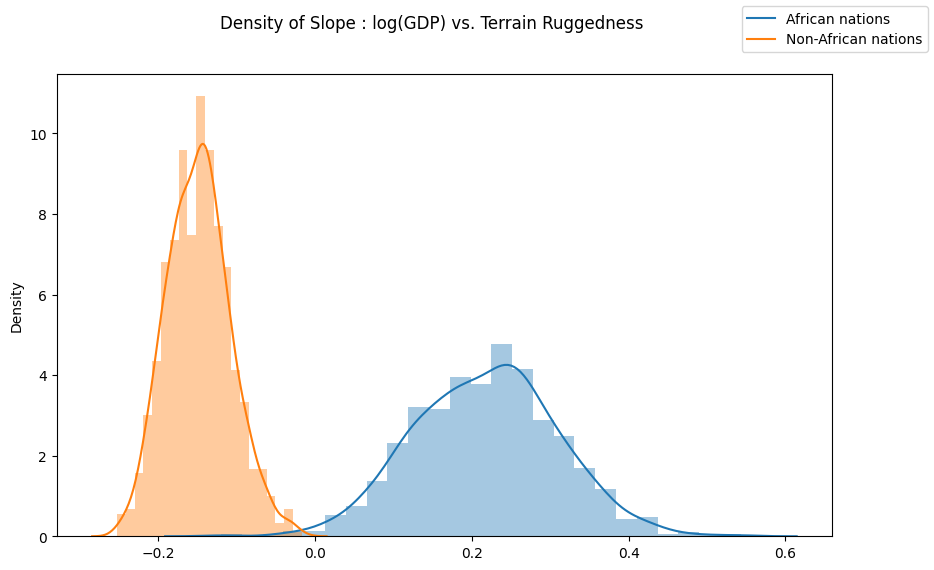

In [46]:
warnings.filterwarnings("ignore")

weight = samples_svi_mcmc["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"})
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
fig.legend()

In [ ]:
# warnings.filterwarnings("ignore")
# weight_load_svi_mcmc = []
# for _ in range(800):
#     # index = 1 corresponds to "linear.weight"
#     weight_load_svi_mcmc.append(pred_loaded_svi_mcmc(x_data)[1])
    
# weight_load_svi_mcmc = torch.stack(weight).detach()
# weight_load_svi_mcmc = weight_load_svi_mcmc.reshape(weight_load_svi_mcmc_load_svi_mcmc.shape[0], 3)
# gamma_within_africa_load_svi_mcmc = weight_load_svi_mcmc[:, 1] + weight_load_svi_mcmc[:, 2]
# gamma_outside_africa_load_svi_mcmc = weight_load_svi_mcmc[:, 1]
# fig = plt.figure(figsize=(10, 6))
# sns.distplot(gamma_within_africa_load_svi_mcmc, kde_kws={"label": "African nations"},)
# sns.distplot(gamma_outside_africa_load_svi_mcmc, kde_kws={"label": "Non-African nations"})
# fig.suptitle("Density of Slope: log(GDP) vs. Terrain Ruggedness");
# fig.legend()

## MCMC

In [ ]:
x_data, y_data = data[:, :-1], data[:, -1]
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x_data, y_data)

In [ ]:
predictive_mcmc = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples_mcmc = predictive_mcmc(x_data)
pred_summary_mcmc = summary(samples_mcmc)

In [ ]:
mu_mcmc = pred_summary_mcmc["_RETURN"]
y_mcmc = pred_summary_mcmc["obs"]
predictions_mcmc = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu_mcmc["mean"],
    "mu_perc_5": mu_mcmc["5%"],
    "mu_perc_95": mu_mcmc["95%"],
    "y_mean": y_mcmc["mean"],
    "y_perc_5": y_mcmc["5%"],
    "y_perc_95": y_mcmc["95%"],
    "true_gdp": y_data,
})

african_nations_mcmc = predictions_mcmc[predictions_mcmc["cont_africa"] == 1]
non_african_nations_mcmc = predictions_mcmc[predictions_mcmc["cont_africa"] == 0]
african_nations_mcmc = african_nations_mcmc.sort_values(by=["rugged"])
non_african_nations_mcmc = non_african_nations_mcmc.sort_values(by=["rugged"])

In [ ]:
warnings.filterwarnings("ignore")

weight_mcmc = samples_mcmc["linear.weight"]
weight_mcmc = weight.reshape(weight.shape[0], 3)
gamma_within_africa_mcmc = weight_mcmc[:, 1] + weight_mcmc[:, 2]
gamma_outside_africa_mcmc = weight_mcmc[:, 1]

fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa_mcmc, kde_kws={"label": "African nations"})
sns.distplot(gamma_outside_africa_mcmc, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
fig.legend()
fig.show()

In [ ]:
# predict_fn_mcmc = Predict(model, guide)
# predict_module_mcmc = torch.jit.trace_module(predict_fn_mcmc, {"forward": (x_data,)}, check_trace=False)
# torch.jit.save(predict_module_mcmc, '/tmp/reg_predict_mcmc.pt')
# pred_loaded_mcmc = torch.jit.load('/tmp/reg_predict_mcmc.pt')
# pred_loaded_mcmc(x_data)
# print(type(x_data))

In [ ]:
# weight = []
# for _ in range(800):
#     # index = 1 corresponds to "linear.weight"
#     weight.append(pred_loaded_mcmc(x_data)[1])
    
# weight = torch.stack(weight).detach()
# weight = weight.reshape(weight.shape[0], 3)
# gamma_within_africa = weight[:, 1] + weight[:, 2]
# gamma_outside_africa = weight[:, 1]
# fig = plt.figure(figsize=(10, 6))
# sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
# sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
# fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
# sns.kdeplot(x=hmc_samples["bA"], y=samples["bR"], ax=axs[0], shade=True, label="HMC")
# sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
# axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
# sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
# sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
# axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
# handles, labels = axs[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right');

# Create a 1x2 subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
# samples_svi["linear.weight"] = samples_svi["linear.weight"].reshape(samples_svi["linear.weight"].shape[0], 3)
# samples_svi_mcmc["linear.weight"] = samples_svi_mcmc["linear.weight"].reshape(samples_svi_mcmc["linear.weight"].shape[0], 3)

# Plot for bA vs. bR
sns.kdeplot(x=samples_svi["linear.weight"][:, 1], y=samples_svi["linear.weight"][:, 2], ax=axs[0], shade=True, label="SVI")
sns.kdeplot(x=samples_svi_mcmc["linear.weight"][:, 1], y=samples_svi_mcmc["linear.weight"][:, 2], ax=axs[0], label="SVI MCMC")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))

# Plot for bR vs. bAR
sns.kdeplot(x=samples_svi["linear.weight"][:, 2], y=samples_svi["linear.weight"][:, 1] + samples_svi["linear.weight"][:, 2], ax=axs[1], shade=True, label="SVI")
sns.kdeplot(x=samples_svi_mcmc["linear.weight"][:, 2], y=samples_svi_mcmc["linear.weight"][:, 1] + samples_svi_mcmc["linear.weight"][:, 2], ax=axs[1], label="SVI MCMC")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

# Add legend to the second subplot
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()




In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Function to generate sample data (replace this with your actual data)
# def generate_sample_data():
#     return {
#         "linear.weight": np.random.rand(100, 3),
#         "gamma_within_africa": np.random.rand(100),
#         "gamma_outside_africa": np.random.rand(100),
#     }

# # Generate sample data (replace this with your actual data)
# samples_svi = generate_sample_data()
# samples_svi_mcmc = generate_sample_data()
# samples_mcmc = generate_sample_data()

# Create a horizontal subplot with three plots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1
weight_svi = samples_svi["linear.weight"]
weight_svi = weight_svi.reshape(weight_svi.shape[0], 3)
gamma_within_africa_svi = weight_svi[:, 1] + weight_svi[:, 2]
gamma_outside_africa_svi = weight_svi[:, 1]
sns.distplot(gamma_within_africa_svi, kde_kws={"label": "African nations"}, ax=axs[0])
sns.distplot(gamma_outside_africa_svi, kde_kws={"label": "Non-African nations"}, ax=axs[0])
axs[0].set_title("Density of Slope: log(GDP) vs. Terrain Ruggedness (SVI)")
axs[0].legend()

# Plot 2
weight_svi_mcmc = samples_svi_mcmc["linear.weight"]
weight_svi_mcmc = weight_svi_mcmc.reshape(weight_svi_mcmc.shape[0], 3)
gamma_within_africa_svi_mcmc = weight_svi_mcmc[:, 1] + weight_svi_mcmc[:, 2]
gamma_outside_africa_svi_mcmc = weight_svi_mcmc[:, 1]
sns.distplot(gamma_within_africa_svi_mcmc, kde_kws={"label": "African nations"}, ax=axs[1])
sns.distplot(gamma_outside_africa_svi_mcmc, kde_kws={"label": "Non-African nations"}, ax=axs[1])
axs[1].set_title("Density of Slope: log(GDP) vs. Terrain Ruggedness (SVI + MCMC)")
axs[1].legend()

# Plot 3
weight_mcmc = samples_mcmc["linear.weight"]
weight_mcmc = weight_mcmc.reshape(weight_mcmc.shape[0], 3)
gamma_within_africa_mcmc = weight_mcmc[:, 1] + weight_mcmc[:, 2]
gamma_outside_africa_mcmc = weight_mcmc[:, 1]
sns.distplot(gamma_within_africa_mcmc, kde_kws={"label": "African nations"}, ax=axs[2])
sns.distplot(gamma_outside_africa_mcmc, kde_kws={"label": "Non-African nations"}, ax=axs[2])
axs[2].set_title("Density of Slope: log(GDP) vs. Terrain Ruggedness (MCMC)")
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.savefig("logGDP-vs-ruggedness_afr-nonafr_comparison3methods.png")
plt.show()
